In [39]:
## Author: Aliénor Lahlou 10/2021

## Introduction

This jupyter notebook allows you to analyse the data of a video of relaxation of Dronpa 2 (D2) under light in the XXX-XX range in order to retrieve the intensity received by the D2 sample.   
The relaxation time depends on the light intensity. Even if the intensity is unknown, a few preliminay tests will allow you to adjust the framerate.  
If the relaxation is too fast, use a density filter and correct the final intensity with the filter OD.  

User: 
- chose the best thresholding method
- enter the framerate of the video
- chose the downscaling kernel size


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import os
import glob


save_folder = "../images/"
extension= ".pdf"

from statsmodels.regression import linear_model
from statsmodels.api import add_constant
from scipy.interpolate import InterpolatedUnivariateSpline

from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion

from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

#%matplotlib widget

In [2]:

def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0

def residuals(parameters, x_data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed


def simple_tau(fluo, time_array, sample_rate):
    """perform monoexponential fit"""
    L = len(time_array) 
    fluo_transition = fluo
    time_transition = np.linspace(0, L - 1, L)
    x0 = [1e5, L/8, 1]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition, fluo_transition, exp_decay))
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]

    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  L//10: #if too high
        tau =  L//10
    if tau < 3: #if too low, increase it
        tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
    parameters_estimated = OptimizeResult.x
    
    if False:
        plt.figure()
        plt.plot(time_transition, fluo_transition, 'o')
        plt.plot(time_transition, exp_decay(parameters_estimated, time_transition))
    parameters_estimated[1] /= sample_rate

    return parameters_estimated

@delayed
@wrap_non_picklable_objects
def parallel_tau(fluo, time_array, sample_rate):
    """monoexponential for joblib"""
    return  simple_tau(fluo, time_array, sample_rate)[1]
    

def plot_map(I_000, I_000_map, save_name, limits = (0,0)):
    """display the results"""
    
    #crop the outliers for correct scaling of the colormap
    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.01)
        Q3 = np.quantile(I_000, 0.95)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    
    
    #map of intensities
    f = plt.figure()
    image = plt.imshow((I_000_map))
    plt.axis("off")
    divider = make_axes_locatable(plt.gca())
    axdef = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
    f.tight_layout()
    plt.savefig(save_folder + "/" +save_name)
    
    
    # histogram of intensities
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()

    fig = plt.figure()
    ax = plt.gca()
    
    plt.xlabel(r"Light intensity ($\mu Eins /m^2/s$)")
    plt.ylabel("")
    ax.tick_params(axis='both', which='major', direction = 'in', top = True, right = True)
    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    plt.savefig(save_folder + "/hist_" + save_name)
    
    np.savetxt(save_folder + "/" + save_name + ".csv", I_000_map, delimiter=",")


    return I_000_map, I_000_distrib

### sequence of images:

In [3]:
ref = 6
video = []
folder = '../data/fps5_blue4_60pm'
for im in glob.glob(folder + "/*.tif"):
    video.append(tiff.imread(im))
    


### video file

In [4]:
file = glob.glob("../data/video_light.tiff")[0]

video = tiff.imread(file)
video.shape
#tiff.imwrite("video_light.tiff", video[0:25])

(25, 608, 968)

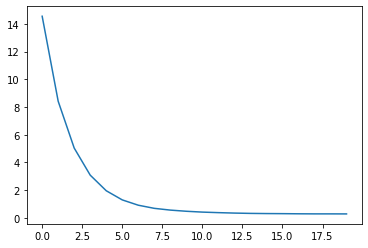

In [5]:
plt.plot(np.mean(video[0:20], axis = (1,2)))

### select first frame

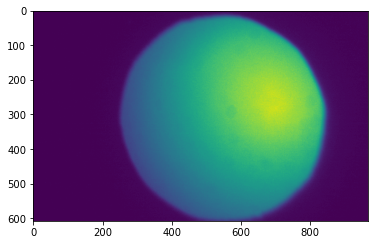

In [6]:
ref = 0 #<-------- modify here enter number of the first frame not in the dark
plt.imshow(video[ref])


### framerate

In [25]:
framerate = 3 # <--------- modify here enter camera framerate here

### try masks

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


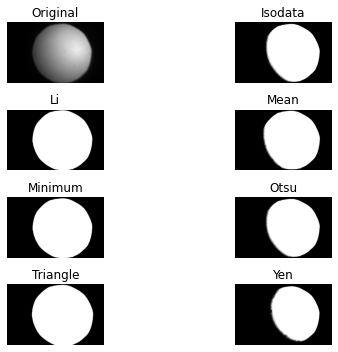

In [26]:
u = skimage.filters.try_all_threshold(video[ref])

### Downscaling

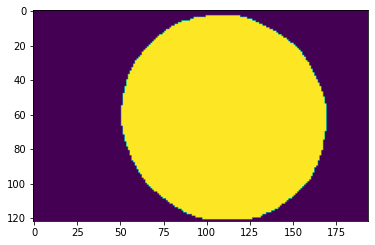

In [40]:
D = 5 #<---------- smoothing & downscaling kernel to accelerate computations
video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
mask = downscale_local_mean(video[ref], (D,D))
threshold = skimage.filters.threshold_minimum(mask) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
#select it from the image that best matches a mask, and copy the corresponding function name printed above

mask = mask>threshold
plt.imshow(mask)


#downscaling 
video_downscaled = []
for i in range(video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

### Fit on the mean of all the unmasked points
It is normal if the fit doesn't appear monoexponential here: it is expected to be multi-exponential if the distribution of intensities is wide-spread

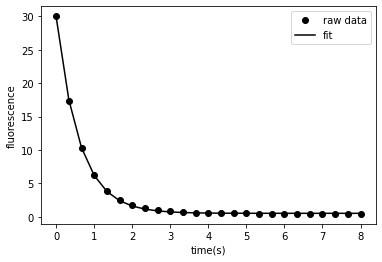

In [41]:
start = ref
stop = 1000  #<------ you can select a shorter segment for the fits
#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)


time = timing[start:stop]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('time(s)')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(save_folder + "mean_decay_fit_D2.png")

### Check no saturation

In [42]:
sat = np.sum(to_evaluate[0:10]==255)/len(to_evaluate[0:10].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


### Run the fits in parallel

In [32]:
#parallel fit on each ixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|██████████████████████████████████████████████████████████████████████████| 11119/11119 [00:02<00:00, 3880.79it/s]


### Debuging: print the fits
**Warning !** re-run the code above and use a high value for the downscaling parameter D in order to minimise the number of plots. 

In [43]:
#Uncomment to debug. 
#for i in tqdm(range(to_evaluate.shape[1])):
#    simple_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) 


## Results

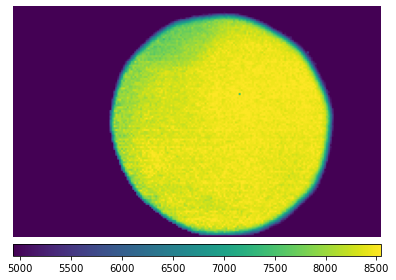

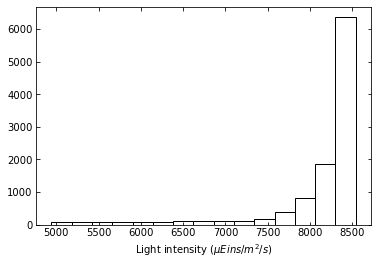

In [44]:
tau_480 = np.array(tau_lists)

I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480
plt.rcParams['image.cmap'] = 'viridis'


 
I, dis = plot_map(I_480, I_480_map,os.path.split(folder)[1] + "_I_480_map_B" + extension)

